这里是一些最终在研究中没有用上的代码

# Sentinel-1数据读取

In [7]:
import sys
sys.path.append("..")
import os
os.chdir("..")
from glob import glob
from functions.dem import SRTM, Egm
from datetime import datetime, timedelta
from functions.dem import wgs2utm, utm2wgs, Coord
from functions.image import s1_bursts, S1, wgs2ecs, ecs2wgs
from os.path import join
from functions.wrf import Wrf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [24]:
def get_s1_paths():
    mode = "vh"
    xml_dirs = [glob(join(i, "*%s*.xml" % mode))
                for i in glob("/run/media/sakura/49ae1bae-b4e6-4a46-bb88-f90370102d2a/*.SAFE/annotation")]
    res = {}
    for i in xml_dirs:
        time = i[0].split("/")[-3][17:25]
        res[time] = (i, [], glob("/run/media/sakura/49ae1bae-b4e6-4a46-bb88-f90370102d2a/aux/orbits/*V%s*.EOF" %
                     (datetime.strptime(time, "%Y%m%d") - timedelta(1)).strftime("%Y%m%d"))[0])
        for j in i:
            k = j.split("/")
            k[-2] = "measurement"
            k[-1] = k[-1][:-4] + ".tiff"
            res[time][1].append("/".join(k))
    return res

csv_path = "data/points.csv"
sDay = "20171104"

In [20]:
def single(s1s, lon, lat, h, length=200, step=1):
    for i in s1s:
        for img in i:
            row, col = img.indirect(lon, lat, h)
            if col < 0:
                break
            if row < 0:
                continue

            x, y = wgs2utm(lon, lat)
            extent = np.arange(-length, length+1, step=step)
            xs, ys = np.meshgrid(extent+x, extent+y)
            lon, lat = utm2wgs(xs, ys)
            h = h + np.zeros(np.shape(lon))

            gen = img.indirect_with_offset(lon, lat, h)
            sp = gen.send(None)
            
            offset = np.zeros(np.shape(lon))
            rows, cols = gen.send(offset)
            data = img.find(rows, cols)

            max_v = np.max(data)
            delta_step = 1
            min_p = int((length-delta_step) / step)
            max_p = int((length+delta_step) / step)
            data[min_p:max_p+1, min_p] = max_v
            data[min_p:max_p+1, max_p] = max_v
            data[min_p, min_p:max_p+1] = max_v
            data[max_p, min_p:max_p+1] = max_v

            plt.imshow(data, origin="lower", cmap="gray")
            plt.colorbar()

            sp, tp = sp[:, 0, 0], wgs2ecs(lon[0, 0], lat[0, 0], h[0, 0])
            dp = tp - sp
            tp2 = dp / np.linalg.norm(dp) + tp
            tp2 = ecs2wgs(tp2[0], tp2[1], tp2[2])
            tp2 = wgs2utm(tp2[0], tp2[1])
            tp = wgs2utm(lon[0, 0], lat[0, 0])
            x, y = (tp2[0] - tp[0])*length, (tp2[1] - tp[1])*length
            plt.plot([length/step, (length+x)/step], [length/step, (length+y)/step])

            plt.show()
            return

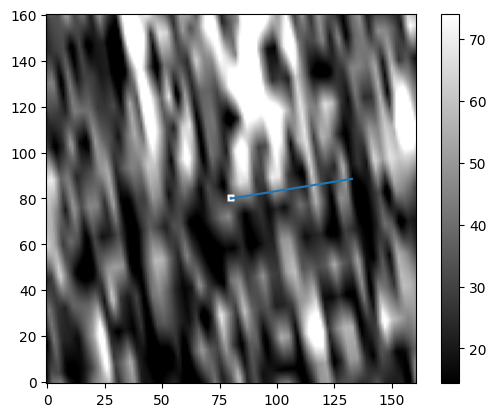

In [21]:
def test_single(sDay):
    xml_paths, tif_paths, eof_path = get_s1_paths()[sDay]
    s1s = []
    for i, j in zip(xml_paths, tif_paths):
        s1s.append([])
        for k in range(s1_bursts(i)):
            s1s[-1].append(S1(i, eof_path, j, k))

    ps = pd.read_csv(csv_path)
    p = ps.loc[ps['id'] == 83].iloc[0]
    lon, lat, h = p['lon'], p['lat'], p['h']
    single(s1s, lon, lat, h, length=80,step=1)

test_single(sDay)

因为投影过的Sentinel-1影像比较模糊，所以有时候还要看看原图长什么样

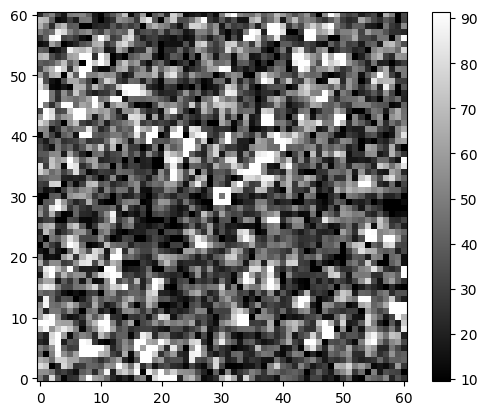

In [23]:
def ori(s1s, lon, lat, h, length=10, step=1):
    for i in s1s:
        for img in i:
            row, col = img.indirect(lon, lat, h)
            if col < 0:
                break
            if row < 0:
                continue

            gen = img.indirect_with_offset(lon, lat, h)
            gen.send(None)
            
            offset = np.zeros(np.shape(lon))
            row, col = gen.send(offset)
            row, col = int(row), int(col)
            row = np.arange(-length,length+1) + row
            col = np.arange(-length,length+1) + col
            cols, rows = np.meshgrid(col, row)
            data = img.find(rows, cols)
            
            max_v = np.max(data)
            delta_step = 1
            min_p = int((length-delta_step) / step)
            max_p = int((length+delta_step) / step)
            data[min_p:max_p+1, min_p] = max_v
            data[min_p:max_p+1, max_p] = max_v
            data[min_p, min_p:max_p+1] = max_v
            data[max_p, min_p:max_p+1] = max_v

            plt.imshow(data, origin="lower", cmap="gray")
            plt.colorbar()
            return

def test_ori(sDay):
    xml_paths, tif_paths, eof_path = get_s1_paths()[sDay]
    s1s = []
    for i, j in zip(xml_paths, tif_paths):
        s1s.append([])
        for k in range(s1_bursts(i)):
            s1s[-1].append(S1(i, eof_path, j, k))

    ps = pd.read_csv(csv_path)
    p = ps.loc[ps['id'] == 83].iloc[0]
    lon, lat, h = p['lon'], p['lat'], p['h']
    ori(s1s, lon, lat, h, length=30,step=1)

test_ori(sDay)

# ALOS-2数据读取

未实现。按照类似TerraSAR-X和Sentinel-1的方法读取的数据总与isce2的读取结果存在出入，尚未查明原因。建议通过isce2完成初步处理。

# 固体地球效应

建议查阅[Pysolid](https://github.com/insarlab/PySolid)及其调用的[Fortran程序](https://geodesyworld.github.io/SOFTS/solid.htm)。